# Stop loss & Take profit with vectorbt

- Reference 1: https://quantnomad.com/using-sl-and-pt-in-backtesting-in-python-with-vectrobt/
- Reference 2: http://qubitquants.pro/customsim_2/index.html

1. Basic stop loss & take profit by setting % relative to entry price

Approach 1:

In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd
from numba import njit
import talib
import time
from datetime import timedelta
import warnings

warnings.filterwarnings("ignore")

In [2]:
yfdata = vbt.YFData.download(
    ["AAPL"],
    start="2021-01-01",
    interval = '1d'
)
ohlcv = yfdata.concat()

fast_ma = vbt.MA.run(ohlcv["Close"], 10, short_name='fast MA')
slow_ma = vbt.MA.run(ohlcv["Close"], 50, short_name='slow MA')

#  If you generated signals using close price, don't forget to shift your signals 
# by one tick forward, for example, with signals.vbt.fshift(1). 
# In general, make sure to use a price that comes after the signal.
long_entries = fast_ma.ma_crossed_above(slow_ma).vbt.signals.fshift(1)

In [3]:
pf = vbt.Portfolio.from_signals(
    ohlcv["Close"],
    entries = long_entries,
    sl_stop=0.025, # in % relative to entry price
    tp_stop=0.05, # in % relative to entry price
    freq = "1D",
    sl_trail = False
)
pf.stats()

Start                         2020-12-31 05:00:00+00:00
End                           2023-08-18 04:00:00+00:00
Period                                662 days 00:00:00
Start Value                                       100.0
End Value                                     100.94466
Total Return [%]                                0.94466
Benchmark Return [%]                          33.648372
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               8.077451
Max Drawdown Duration                 453 days 00:00:00
Total Trades                                          8
Total Closed Trades                                   8
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       37.5
Best Trade [%]                                 6.000907
Worst Trade [%]                               -3

Approach 2: 

In [43]:
# A trailing stop is an order type designed to lock in profits 
# or limit losses as a trade moves favorably. 
# Trailing stops only move if the price moves favorably.

"""
Default arguments will generate an exit signal strictly between two entry signals.
            If both entry signals are too close to each other, no exit will be generated.

            To ignore all entries that come between an entry and its exit,
            set `until_next` to False and `skip_until_exit` to True.

            To remove all entries that come between an entry and its exit,
            set `chain` to True. This will return two arrays: new entries and exits.

""""

entries, exits = long_entries.vbt.signals.generate_ohlc_stop_exits(
            ohlcv["Open"],
            ohlcv["High"],
            ohlcv["Low"],
            ohlcv["Close"],
            chain=True,
            sl_stop = 0.025, # in % relative to entry price
            tp_stop = 0.05, # in % relative to entry price
            sl_trail=False,
)

In [44]:
pf = vbt.Portfolio.from_signals(
    ohlcv["Close"],
    entries = entries,
    exits = exits,
    freq = "1D",
)
pf.stats()

Start                         2020-12-31 05:00:00+00:00
End                           2023-08-18 04:00:00+00:00
Period                                662 days 00:00:00
Start Value                                       100.0
End Value                                    101.336018
Total Return [%]                               1.336018
Benchmark Return [%]                          33.648372
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               9.739391
Max Drawdown Duration                 382 days 00:00:00
Total Trades                                          8
Total Closed Trades                                   8
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       50.0
Best Trade [%]                                  6.21457
Worst Trade [%]                               -5

In [24]:
pf.trades.records

id  col      size  entry_idx  entry_price  entry_fees  exit_idx  \
0   0    0  0.754895         69   132.468735         0.0        82   
1   1    0  0.748830        117   130.591278         0.0       126   
2   2    0  0.703053        207   147.147629         0.0       217   
3   3    0  0.589195        279   174.740570         0.0       281   
4   4    0  0.565842        311   174.066528         0.0       315   
5   5    0  0.655838        386   149.077301         0.0       396   
6   6    0  0.717898        476   147.381195         0.0       480   
7   7    0  0.709486        521   145.310028         0.0       526   

   exit_price  exit_fees       pnl    return  direction  status  parent_id  
0  129.542053        0.0 -2.209338 -0.022093          0       1          0  
1  138.152313        0.0  5.661930  0.057898          0       1          1  
2  146.441666        0.0 -0.496330 -0.004798          0       1          2  
3  167.167297        0.0 -4.462134 -0.043340          0       1          3  
4  172.787796        0.0 -0.723560 -0.007346          0       1          4  
5  161.327515        0.0  8.034156  0.082174          0       1          5  
6  143.607315        0.0 -2.709262 -0.025606          0       1          6  
7  153.843628        0.0  6.054471  0.058727          0       1          7

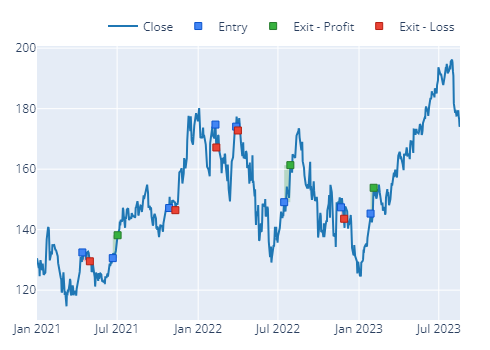

In [34]:
# how to plot stop loss and take profit like this: https://camo.githubusercontent.com/77cc6a4883d6274bdca3ed019a1d1744810080ee413304f6c9614275e0f6a353/68747470733a2f2f692e696d6775722e636f6d2f343462334335582e706e67 
pf.trades.plot().show()

2. Trailing stop loss in %

In [7]:
long_entries = fast_ma.ma_crossed_above(slow_ma)

pf = vbt.Portfolio.from_signals(
    ohlcv["Close"],
    entries = long_entries,
    sl_stop=0.025, # in % relative to entry price
    tp_stop=0.05, # in % relative to entry price
    freq = "1D",
    sl_trail = True, 
    upon_opposite_entry='close',
)

In [8]:
pf.stats()

Start                         2020-12-31 05:00:00+00:00
End                           2023-08-18 04:00:00+00:00
Period                                662 days 00:00:00
Start Value                                       100.0
End Value                                    109.149934
Total Return [%]                               9.149934
Benchmark Return [%]                          33.648372
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               9.700061
Max Drawdown Duration                 268 days 00:00:00
Total Trades                                          8
Total Closed Trades                                   8
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       37.5
Best Trade [%]                                 8.217357
Worst Trade [%]                               -4

3. Time based stop loss

Reference: https://github.com/polakowo/vectorbt/issues/175

3. ATR based stop loss

Reference 1: https://github.com/polakowo/vectorbt/issues/269

Reference 2: https://www.tradingwithrayner.com/atr-indicator/

In [10]:
symbols = ["GBPUSD=X","AUDUSD=X"]
yfdata = vbt.YFData.download(symbols)
data = yfdata.concat() # OHCLV data of the symbols

In [11]:
ATR = vbt.ATR.run(data["High"],data["Low"],data["Close"], window=14)
atr = ATR.atr.vbt * pd.Index(range(len(symbols)), name='risk_level') # format the ATR into MultiIndex
atr

atr_window                      14          
symbol                    GBPUSD=X  AUDUSD=X
Date                                        
2003-12-01 00:00:00+00:00      NaN       NaN
2003-12-02 00:00:00+00:00      NaN       NaN
2003-12-03 00:00:00+00:00      NaN       NaN
2003-12-04 00:00:00+00:00      NaN       NaN
2003-12-05 00:00:00+00:00      NaN       NaN
...                            ...       ...
2023-08-13 23:00:00+00:00      0.0  0.007549
2023-08-14 23:00:00+00:00      0.0  0.007337
2023-08-15 23:00:00+00:00      0.0  0.007154
2023-08-16 23:00:00+00:00      0.0  0.007389
2023-08-17 23:00:00+00:00      0.0  0.007063

[5132 rows x 2 columns]